# Import Dependencies

In [ ]:
%pip install tensorflow opencv-python mediapipe sklearn matplotlib

In [11]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints from Mediapipe Holistic

In [12]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [13]:
def mediapipe_detection(image, model):
    # Adjust colors
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Disable writing image flags
    image.flags.writeable = False

    # Run image through holistic mp model
    results = model.process(image)

    # Re-enable writing image flags
    image.flags.writeable = True

    # Re-color image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [14]:
def draw_landmarks(image, results) -> None:
    # Face landmarks/connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, 
                              mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(30,220,0),  thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(100,100,30), thickness=1, circle_radius=0.1))
    # Pose landmarks/connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, 
                              mp_holistic.POSE_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(40,255,0),  thickness=2, circle_radius=4), 
                              mp_drawing.DrawingSpec(color=(150,150,45), thickness=2, circle_radius=2))
    # Left hand landmarks/connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, 
                              mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(40,255,0),  thickness=2, circle_radius=4), 
                              mp_drawing.DrawingSpec(color=(200,200,60), thickness=2, circle_radius=2))
    # Right hand landmarks/connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, 
                              mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(40,255,0),  thickness=2, circle_radius=4), 
                              mp_drawing.DrawingSpec(color=(200,200,60), thickness=2, circle_radius=2))

In [57]:
# Capture video feed
cap = cv2.VideoCapture(0)

# Set mp model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        
        # Detect nodes
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks and connections
        draw_landmarks(image, results)

        # Render feed
        cv2.imshow('OpenCV Live Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

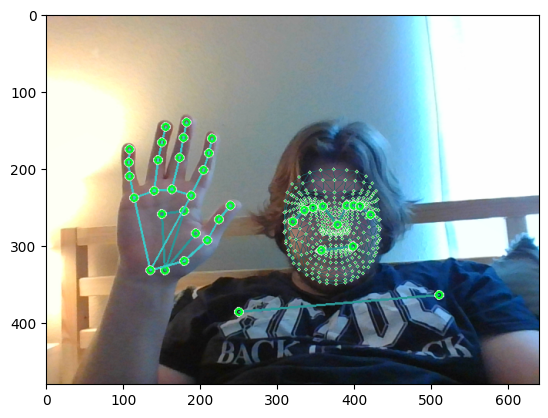

In [27]:
# Display pixel graph with landmarks
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [16]:
def extract_keypoints(results):
    # Extract position values from face landmarks
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    
    # Extract position values from pose landmarks
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    
    # Extract position values from left hand landmarks
    lhand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    
    # Extract position values from right hand landmarks
    rhand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    
    # Return all positional keypoints from all body parts
    return np.concatenate([pose, face, lhand, rhand])

# Setup Folders for Data Collection

**TODO:** 
add actions:
- how are you?
- please
- where
- what
- he/she
- come here

In [17]:
# Path for exported data arrays
DATA_PATH = os.path.join('MP_DATA')

# Detectable actions
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Number of videos per action
num_sequences = 30

# Number of frames per video
sequence_length = 30

In [23]:
# Create a new directory for each video (30) for each action
#   (only creates directory if directory does not already exist)
for action in actions:
    for sequence in range(num_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect Keypoint Data for Training and Testing Model

In [32]:
# Capture video feed
cap = cv2.VideoCapture(0)

# Set mp model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences
        for sequence in range(num_sequences):
            # Loop through frames
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                
                # Detect nodes
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks and connections
                draw_landmarks(image, results)

                # Add collection breaks
                if frame_num == 0:
                    # Display collection text
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 1, cv2.LINE_AA)
                    cv2.putText(image, f'COLLECTING FRAMES FOR {action}, Video Number {sequence}', 
                                (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    
                    # Render feed
                    cv2.imshow('OpenCV Live Feed', image)

                    # Wait before collecting next sequence
                    cv2.waitKey(2000)
                else:
                    # Display collection text
                    cv2.putText(image, f'COLLECTING FRAMES FOR {action}, Video Number {sequence}', 
                                (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    
                    # Render feed
                    cv2.imshow('OpenCV Live Feed', image)

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
        
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

In [14]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [ ]:
%pip install scikit-learn scipy matplotlib

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [33]:
# Sequence shape is num of sequences, frames per sequence, keypoints per frame
sequences, labels = [], []
# Loop through actions
for action in actions:
    # Loop through sequences
    for sequence in range(num_sequences):
        window = []
        # Loop through frames
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f'{frame_num}.npy'))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [35]:
np.array(sequences).shape

(90, 30, 1662)

In [36]:
# Create numpy arrays for sequences and labels
x = np.array(sequences)
y = to_categorical(labels).astype(int)

# Train and test model from numpy arrays with 95%-5% train/test split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [42]:
y_test.shape

(5, 3)

# Build and Train the LSTM Neural Network

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [48]:
# Setup TensorBoard web-app statistics
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [53]:
# Build LSTM Model
model = Sequential()
# LSTM layer 1
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))

# LSTM layer 2
model.add(LSTM(128, return_sequences=True, activation='relu'))

# LSTM layer 3
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Dense layer 1
model.add(Dense(64, activation='relu'))

# Dense layer 2
model.add(Dense(32, activation='relu'))

# Dense layer 3
model.add(Dense(actions.shape[0], activation='softmax'))

In [54]:
# Compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Train model
model.fit(x_train, y_train, epochs=2000, callbacks=[tb_callback])

In [51]:
del model

In [56]:
# Display model metrics
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

# Make Predictions

In [58]:
res = model.predict(x_test)

1/1 [==============================] - 1s 1s/step


# Save Weights

In [59]:
model.save('action.h5')

In [ ]:
model.load_weights('action.h5')

# Make Evaluation using Confusion Matrix and Accuracy Scores

In [60]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [61]:
# Make evaluations
yhat = model.predict(x_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

1/1 [==============================] - 0s 66ms/step


In [64]:
yhat

[0, 0, 0, 0, 0]

In [65]:
ytrue

[2, 0, 0, 2, 1]

In [66]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 3],
        [0, 2]],

       [[4, 0],
        [1, 0]],

       [[3, 0],
        [2, 0]]], dtype=int64)

In [67]:
accuracy_score(ytrue, yhat)

0.4

# Test Model in Real Time

In [89]:
# Detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.4

# Capture video feed
cap = cv2.VideoCapture(0)

# Set mp model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        
        # Detect nodes
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks and connections
        draw_landmarks(image, results)

        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30::]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

        # Visualization logic:
        # Create sentence from keypoint results
        if len(predictions) > 0 and np.unique(predictions[-10:])[0] == np.argmax(res):
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])
        
            # Constrict sentence length
            if len(sentence) > 5:
                sentence = sentence[-5:]

        # Display sentence
        cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (255,255,255), 2, cv2.LINE_AA)

        # Render feed
        cv2.imshow('OpenCV Live Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 46ms/step
iloveyou
1/1 [==============================] - 0s 70ms/step
iloveyou
1/1 [==============================] - 0s 56ms/step
hello
1/1 [==============================] - 0s 51ms/step
thanks
1/1 [==============================] - 0s 58ms/step
hello
1/1 [==============================] - 0s 58ms/step
iloveyou
1/1 [==============================] - 0s 57ms/step
thanks
1/1 [==============================] - 0s 54ms/step
iloveyou
1/1 [==============================] - 0s 44ms/step
hello
1/1 [==============================] - 0s 63ms/step
iloveyou
1/1 [==============================] - 0s 52ms/step
iloveyou
1/1 [==============================] - 0s 50ms/step
iloveyou
1/1 [==============================] - 0s 47ms/step
iloveyou
1/1 [==============================] - 0s 56ms/step
iloveyou
1/1 [==============================] - 0s 59ms/step
thanks
1/1 [==============================] - 0s 46ms/step
hello
1/1 [==============================] - 0s 

In [86]:
cap.release()
cv2.destroyAllWindows()